In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

#### Importing the dataset

rating_dataset is the Surprise dataset that can be used when analyzing the full dataset.
<br>
rating_matrix is the numpy array that has columns: userId, movieId, rating, timestamp

In [2]:
from surprise import Reader, Dataset

In [3]:
# Read data set using pandas and surprise. Data is stored in rating_dataset

df=pd.read_csv('ml-latest-small/ratings.csv')
# reader = Reader(rating_scale=(1,5))
reader = Reader(line_format='user item rating timestamp', sep=',', rating_scale=(0.5, 5), skip_lines=1)

rating_dataset = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)
rating_matrix = df.values

# Get the all ratings for each movie. Key is movie ID, value of an array of ratings.
ratings_by_movie_id = {}
for row in rating_dataset.raw_ratings:
    if row[1] not in ratings_by_movie_id:
        ratings_by_movie_id[row[1]] = []
    ratings_by_movie_id[row[1]].append(row[2])

# Count number of users and movies.
num_users = np.size(np.unique(rating_matrix[:,0]))
num_movies = np.size(np.unique(rating_matrix[:,1]))

#### Question 1

In [17]:
# Calculate sparsity, defined as: (total number of available ratings) / (total number of possible ratings)

num_available_ratings = np.size(rating_matrix[:,0])
num_possible_ratings = num_users*num_movies

sparsity = num_available_ratings / num_possible_ratings

print('Sparsity = {}'.format(sparsity))

Sparsity = 0.016999683055613623


#### Question 2

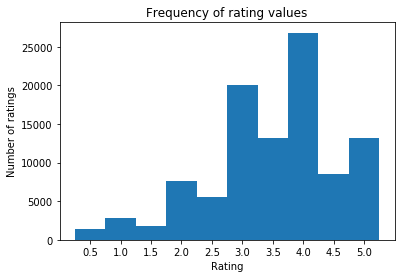

In [28]:
# Plot a histogram showing the frequency of rating values

ratings = rating_matrix[:,2]
plt.figure()
# plt.hist(ratings, 10)
plt.hist(ratings, np.arange(0.5, 6, 0.5))
plt.title('Frequency of rating values')
plt.xlabel('Rating')
plt.ylabel('Number of ratings')
plt.xticks(np.arange(0.75, 5.75, 0.5), np.arange(0.5, 5.5, 0.5))
plt.show()

#### Question 3

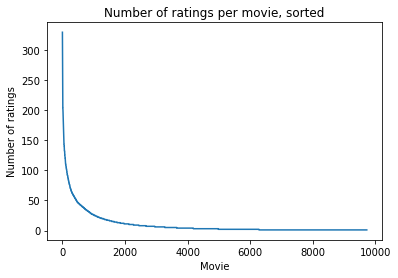

In [6]:
# Distribution of number of ratings received per movie.

movies = rating_matrix[:,1]
movie_id, counts = np.unique(movies, return_counts=True)
counts_sorted = np.sort(counts)[::-1]

plt.figure()
plt.plot(counts_sorted)
plt.title('Number of ratings per movie, sorted')
plt.xlabel('Movie')
plt.ylabel('Number of ratings')
plt.show()

#### Question 4

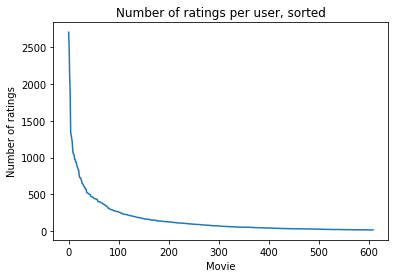

In [7]:
# Distribution of number of ratings given per user

users = rating_matrix[:,0]
user_id, counts = np.unique(users, return_counts=True)
counts_sorted = np.sort(counts)[::-1]

plt.figure()
plt.plot(counts_sorted)
plt.title('Number of ratings per user, sorted')
plt.xlabel('Movie')
plt.ylabel('Number of ratings')
plt.show()

#### Question 6

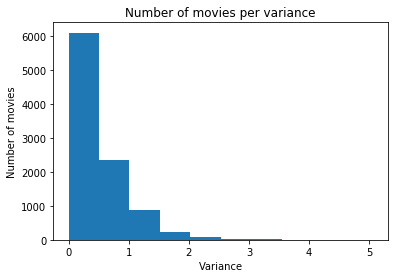

In [30]:
# Histogram of variance in ratings per movie

var_by_movie_id = {}
for key in ratings_by_movie_id.keys():
    var_by_movie_id[key] = np.var(ratings_by_movie_id[key])
    
variances = list(var_by_movie_id.values())

plt.figure()
plt.hist(variances)
plt.title('Number of movies per variance')
plt.xlabel('Variance')
plt.ylabel('Number of movies')
plt.show()

#### Trimming the dataset

The trimmed data set is in a format the Surprise can take as input.

##### Variable names:
Popular movie dataset: rating_popular_dataset 
<br>
Unpopular movie dataset: rating_unpopular_dataset
<br>
High variance movie dataset: rating_unpopular_dataset

In [9]:
# Get the movie ids that are being kept in each trimming. 

ratings_by_movie_id = {}
for row in rating_dataset.raw_ratings:
    if row[1] not in ratings_by_movie_id:
        ratings_by_movie_id[row[1]] = []
    ratings_by_movie_id[row[1]].append(row[2])

var_by_movie_id = {}
for key in ratings_by_movie_id.keys():
    var_by_movie_id[key] = np.var(ratings_by_movie_id[key])
    
pop_movie_ids = [k for k in ratings_by_movie_id if len(ratings_by_movie_id[k]) > 2]
unpop_movie_ids = [k for k in ratings_by_movie_id if len(ratings_by_movie_id[k]) <= 2]
highvar_movie_ids = [k for k in var_by_movie_id if var_by_movie_id[k] >= 2 and len(ratings_by_movie_id[k]) >= 5]

In [10]:
# Make a new dataframe for each trimmed set.

df = pd.read_csv('ml-latest-small/ratings.csv')
df_popular = df[df['movieId'].isin(pop_movie_ids)]
df = pd.read_csv('ml-latest-small/ratings.csv')
df_unpopular = df[df['movieId'].isin(unpop_movie_ids)]
df = pd.read_csv('ml-latest-small/ratings.csv')
df_highvar = df[df['movieId'].isin(highvar_movie_ids)]

In [11]:
# Make a new surprise Dataset for each trimmed set.

rating_popular_dataset = Dataset.load_from_df(df_popular[['userId', 'movieId', 'rating']], reader)
rating_unpopular_dataset = Dataset.load_from_df(df_unpopular[['userId', 'movieId', 'rating']], reader)
rating_highvar_dataset = Dataset.load_from_df(df_highvar[['userId', 'movieId', 'rating']], reader)

##### ~ Global functions ~

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

def custom_crossval(X_train, y_train, model, num_folds=10, metrics=['RMSE', 'MAE', 'accuracy'],
                    randomize=True, include_inds=False):
    '''
    Requires a model that has the following functions:
        model.fit(X, y): fits the model on a particular set of X/y
        model.predict(X): predicts y given an input of X
    '''
    X_train_folds = []
    y_train_folds =  []
    X_val_folds = []
    y_val_folds = []
    
    # necessary for some models (Naive)
    train_inds = []
    val_inds = []
    
    # initialize cumulative errors object
    cumulative_metrics = {}
    for met in metrics:
        cumulative_metrics[met] = 0
    
    k = num_folds
    
    ##############################################################################
    # 1. Divide dataset into training and validation folds
    idx = np.arange(X_train.shape[0])
    fold_size = X_train.shape[0] // num_folds
    
    # randomize indices
    if randomize:
        np.random.shuffle(idx)

    for i in range(num_folds):
        test_idx = idx[i*fold_size:(i+1)*fold_size]
        train_idx = np.concatenate((idx[:i*fold_size:], idx[(i+1)*fold_size:]))

        X_train_folds.append(X_train[train_idx])
        y_train_folds.append(y_train[train_idx])

        X_val_folds.append(X_train[test_idx])
        y_val_folds.append(y_train[test_idx])
        
        train_inds.append(train_idx)
        val_inds.append(test_idx)
        
    ##############################################################################
    # 2. Train on train set, test on validation set, calculate errors
    for i in range(len(X_train_folds)):
        # train model on the train folds (k-1 folds):
        model.fit(X_train_folds[i], y_train_folds[i])

        # measure error of test predictions
        if include_inds:
            y_pred = model.predict(X_val_folds[i], inds=val_inds[i])
        else:
            y_pred = model.predict(X_val_folds[i])
        
        # calculate errors:
        y_actual = y_val_folds[i]
        for met in metrics:
            if met == 'RMSE':
                rms = sqrt(mean_squared_error(y_actual, y_pred))
                cumulative_metrics[met] += rms
            elif met == 'MAE':
                mae = mean_absolute_error(y_actual, y_pred)
                cumulative_metrics[met] += mae
            elif met == 'accuracy':
                num_correct = np.sum(y_pred == y_actual)
                cumulative_metrics[met] += num_correct / y_val_folds[i].shape[0]
            else:
                raise Exception("Error: requested error ('{}') is not incoporated into this function yet.".format(met))
    
    ##############################################################################
    # 3. Average and return metrics object
    for met in metrics:
        cumulative_metrics[met] = cumulative_metrics[met] / len(X_train_folds)
    return cumulative_metrics

#### Trimming the data set

In [92]:
# Popular movie trimming

nz_movie = np.count_nonzero(data, axis=0)
unpop_movies = []
for i in range(len(nz_movie)):
    if nz_movie[i] <= 2:
        unpop_movies.append(i)

data_popular = np.delete(data, unpop_movies, axis=1)
# print(np.unique(np.count_nonzero(data_popular, axis=0)))
# print(data_popular)

In [93]:
# Unpopular movie trimming

nz_movie = np.count_nonzero(data, axis=0)
pop_movies = []
for i in range(len(nz_movie)):
    if nz_movie[i] > 2:
        pop_movies.append(i)
        
data_unpopular = np.delete(data, pop_movies, axis=1)
# print(np.unique(np.count_nonzero(data_unpopular, axis=0)))

In [8]:
# High variance movie trimming

nz_movie = np.count_nonzero(data, axis=0)
movies_less5 = []
for i in range(len(nz_movie)):
    if nz_movie[i] < 5:
        movies_less5.append(i)

data_more5 = np.delete(data, movies_less5, axis=1)

variances = np.zeros(np.shape(data_more5)[1])
for i in range(np.shape(data_more5)[1]):
    variances[i] = np.var(data_more5[:, i])

lowvar_movies = []
for i in range(np.shape(data_more5)[1]):
    if variances[i] < 2:
        lowvar_movies.append(i)
data_highvar = np.delete(data_more5, lowvar_movies, axis=1)

# print(data_highvar.shape)
# print(np.var(data_highvar[:,13]))

### NMF

In [13]:
from surprise import NMF
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold

In [274]:
# df=pd.read_csv('ml-latest-small/ratings.csv')
# # reader = Reader(rating_scale=(1,5))
# reader = Reader(line_format='user item rating timestamp', sep=',', rating_scale=(0.5, 5), skip_lines=1)

# rating_dataset = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)
# rating_matrix = df.values

In [275]:
# ratings = rating_matrix[:,2]
# # plt.hist(ratings, np.arange(0.5, 6, 0.5))
# plt.figure()
# plt.hist(ratings, 10)
# plt.title('Number of ratings per rating')
# plt.xlabel('rating')
# plt.ylabel('number of ratings')
# plt.show()

#### Question 18

In [15]:
# rmse_scores = []
# mae_scores = []

# for k in range(2, 51, 2):
#     nmf = NMF(n_factors=k)
#     result = cross_validate(nmf, rating_dataset, measures=['rmse', 'mae'], cv=10)
    
#     rmse = np.mean(result['test_rmse'])
#     mae = np.mean(result['test_mae'])
    
#     print('k = {}'.format(k))
#     print(rmse)
#     print(mae)
#     print(' ')
    
#     rmse_scores.append(rmse)
#     mae_scores.append(mae)

nmf = NMF(n_factors=2)
result = cross_validate(nmf, rating_dataset, measures=['rmse', 'mae'], cv=10)

rmse = np.mean(result['test_rmse'])
mae = np.mean(result['test_mae'])

print('k = {}'.format(2))
print(rmse)
print(mae)
print(' ')


k = 2
1.1469551508106275
0.9644573451462106
 


#### Question 19

In [16]:
nmf = NMF(n_factors=2)
result = cross_validate(nmf, rating_popular_dataset, measures=['rmse', 'mae'], cv=10)

rmse = np.mean(result['test_rmse'])
mae = np.mean(result['test_mae'])

# print('k = {}'.format(k))
print(rmse)
print(mae)
print(' ')

# rmse_scores.append(rmse)
# mae_scores.append(mae)

1.138293972765405
0.9616102564012847
 


#### Question 30

Calculate the average rating, $\mu_i$, for each user rating, $r_i$

##### Define Naive model

In [14]:
class Naive():
    '''
    Custom collaborative filter designed to work with the cross-validation function
    '''
    
    # mean ratings, one required per user
    mu_i = None
    
    def __init__(self, X_train):
        self.mu_i = np.zeros(X_train.shape)
        self.fit(X_train, None, enabled=True)
        
    # calculate mu_i for training
    def fit(self, X, y, enabled=False):
        if enabled:
            self.mu_i = np.mean(X, axis=1)
        
    # return mu_i as rating prediction (for each movie)
    def predict(self, X, inds=None):
        if inds is None:
            return np.repeat(np.reshape(self.mu_i, (self.mu_i.shape[0], 1)), X.shape[1], axis=1)
        else:
            # return a specific set of mu_i's:
            return np.repeat(np.reshape(self.mu_i[inds], (self.mu_i[inds].shape[0], 1)), X.shape[1], axis=1)

In [15]:
model = Naive(data)
mu_i = model.mu_i
print("average rating shape:", mu_i.shape, "- should be", num_users)
print("average rating range:", np.min(mu_i), np.max(mu_i))

print("\nshould match manual calculation:")
mu_i = np.mean(data, axis=1)
print("average rating shape:", mu_i.shape, "- should be", num_users)
print("average rating range:", np.min(mu_i), np.max(mu_i))

y_pred = model.predict(data)
print(data.shape, y_pred.shape)

average rating shape: (610,) - should be 610
average rating range: 0.0026223776223776225 0.941125051419169

should match manual calculation:
average rating shape: (610,) - should be 610
average rating range: 0.0026223776223776225 0.941125051419169
(610, 9724) (610, 9724)


In [16]:
error = custom_crossval(data, data, model, num_folds=10, metrics=['RMSE'],
                        randomize=False, include_inds=True)

print('Average RMSE:', error['RMSE'])

Average RMSE: 0.46125510728767294


#### Question 31

In [17]:
model = Naive(data_popular)
error = custom_crossval(data_popular, data_popular, model, num_folds=10, metrics=['RMSE'],
                        randomize=False, include_inds=True)

print('Average RMSE for popular-trimmed data:', error['RMSE'])

Average RMSE for popular-trimmed data: 0.6161242838825147


#### Question 32

In [18]:
model = Naive(data_unpopular)
error = custom_crossval(data_unpopular, data_unpopular, model, num_folds=10, metrics=['RMSE'],
                        randomize=False, include_inds=True)

print('Average RMSE unpopular-trimmed data:', error['RMSE'])

Average RMSE unpopular-trimmed data: 0.14665174343247717


#### Question 33

In [19]:
model = Naive(data_highvar)
error = custom_crossval(data_highvar, data_highvar, model, num_folds=10, metrics=['RMSE'],
                        randomize=False, include_inds=True)

print('Average RMSE high-variance-trimmed data:', error['RMSE'])

Average RMSE high-variance-trimmed data: 1.520687897531603
